# Linear Regression using Simple AutoDiff Library

In this notebook we will implement linear regression, using the simple_autodiff library to estimate the optimal parameters.

Firstly, we will define a simple linear regression task to solve, in the form (linear + guassian noise): `y = mx + c + N(0, std)`

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(seed=4)

In [3]:
num_examples = 50
min_bound = 0.0
max_bound = 10.0
target_m = 1.6
target_c = -2.1
noise_std = 1.0

First let's create our fake data.

In [4]:
def linear(x, m, c):
    return m * x + c

In [5]:
x = np.random.uniform(low=min_bound, high=max_bound, size=num_examples)
y = linear(x, target_m, target_c) + np.random.normal(0, noise_std, size=num_examples)

In [6]:
print(x.shape, y.shape)
print(x.dtype, y.dtype)

(50,) (50,)
float64 float64


Next, let's define a plotting utility function we'll use throughout.

In [7]:
def plot(x, y, target_params, predicted_params=None):
    plt.figure(figsize=(12, 8))
    plt.scatter(x, y, marker='x', color='k', label="data points")

    x_vals = np.linspace(min_bound, max_bound, 10)

    y_target = linear(x_vals, target_params[0], target_params[1])
    plt.plot(x_vals, y_target, linestyle=':', color='b', label="ground truth")

    if predicted_params is not None:
        y_predicted = linear(x_vals, predicted_params[0], predicted_params[1])
        plt.plot(x_vals, y_predicted, linestyle='--', color='r', label="prediction")

    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

We can now view our data, showing also the line used to generate the data.

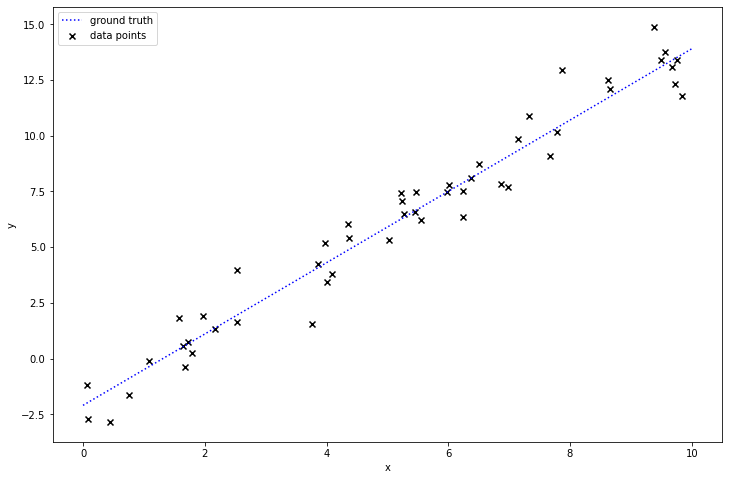

In [8]:
plot(x, y, (target_m, target_c))

Now let's set up our model using simple_autodiff. First we need to import some useful modules and functions.

In [9]:
from simple_autodiff.tensor import InputTensor, ParameterTensor
from simple_autodiff.nn.functional import mean_squared_error
from simple_autodiff.nn.initialisers import uniform_initialiser
from simple_autodiff.nn.optim import SGD

Next we will set up some of the tensors and functions we will need in our training loop

In [10]:
# Define our trainable weights matrix first
model_weights = ParameterTensor(uniform_initialiser((1, 2))) # [1, 2]

In [11]:
# Define the model we will run in the forward pass
def model(X, W):
    return X * W.T # [N, 2] * [2, 1] -> [N, 1]

In [12]:
# Prepare our dataset (need to add column of ones so we can include offset term c in matrix multiplication)
data = np.hstack((np.expand_dims(x, 1), np.ones((x.shape[0], 1), dtype=np.float32)))
labels = y.copy()

In [13]:
# Check the shape and types of our data match what we expect
print(data.shape, labels.shape)
print(data.dtype, labels.dtype)

(50, 2) (50,)
float64 float64


Let's visualise the random starting model. It most probably won't fit the data points well at this stage.

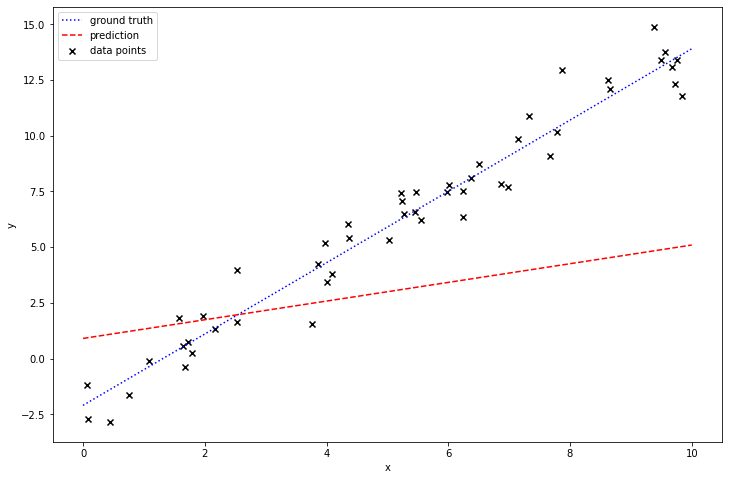

In [14]:
plot(x, y, (target_m, target_c), model_weights.data.squeeze().tolist())

Now we will define our training loop. Since our dataset is small we'll use all examples in every iteration - Batch Gradient Descent.

In [15]:
def forward_pass(data, labels, model_weights):
        X = InputTensor(data)
        Y = InputTensor(labels)
        Y_predicted = model(X, model_weights)
        loss = mean_squared_error(Y_predicted.squeeze(), Y)
        return loss, Y_predicted

In [16]:
def train(data, labels, model_weights, optimiser, iterations=1):
    loss_history = []

    for i in range(iterations):
        loss, Y_predicted = forward_pass(data, labels, model_weights)
        loss_history.append(loss.data.copy())
        loss.backward()
        optimiser.step()

    return loss_history, model_weights

Let's have a look at what our loss value is to start with.

In [17]:
loss, _ = forward_pass(data, labels, model_weights)
loss.result()

22.913336

We can compare this to the error for our ground truth model. Our value should be a lot higher than this before training.

In [18]:
np.mean(((target_m * x + target_c) - y)**2)

0.9941043962265982

We can also visualise our graph to check everything looks about right using the following code. In the following pink are operations, orange are input tensors, green are parameter tensors and grey are intermediate tensors.

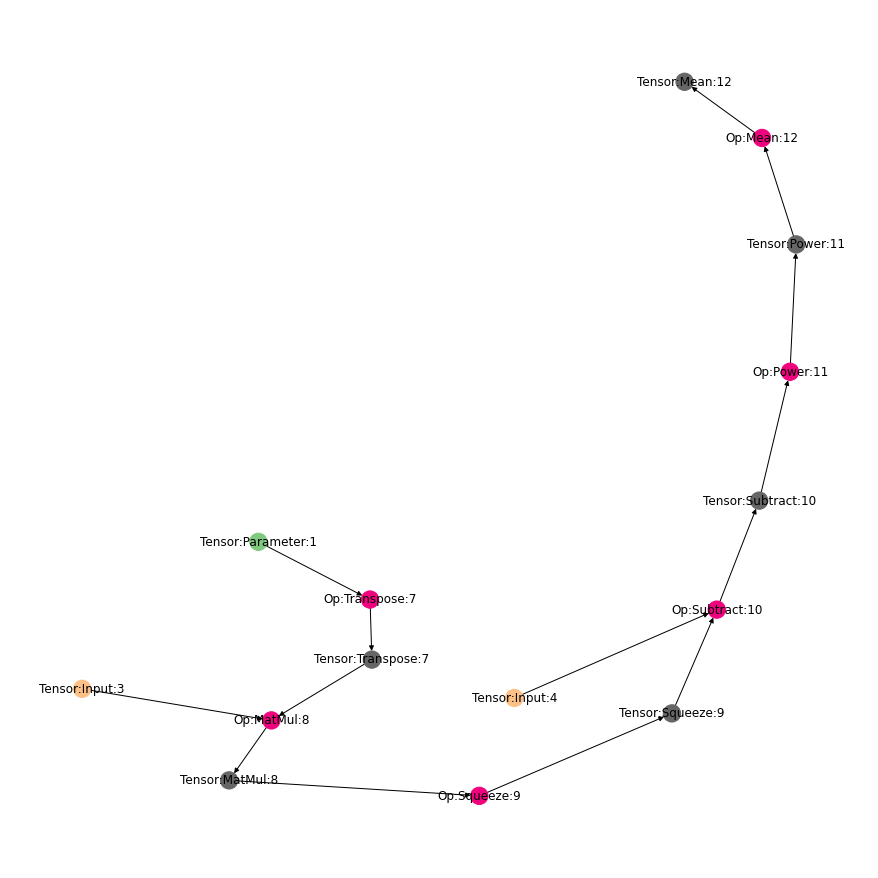

In [19]:
loss, _ = forward_pass(data, labels, model_weights)
loss.visualise()

Lastly we need to define our optimiser.

In [20]:
optimiser = SGD(lr=1e-3, momentum=0.9)

Now let's train our model:

In [21]:
loss_history, model_weights = train(data, labels, model_weights, optimiser, iterations=1000)

Let's plot the loss to see if optimisation has converged.

In [22]:
x_vals = np.arange(len(loss_history)).tolist()
y_vals = [np.log(l) for l in loss_history]

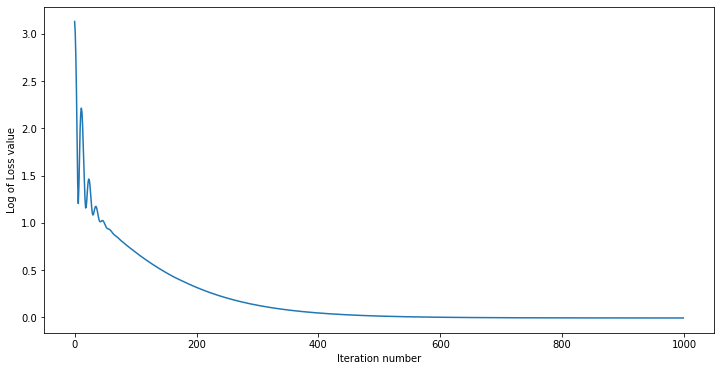

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(x_vals, y_vals)
plt.xlabel("Iteration number")
plt.ylabel("Log of Loss value")
plt.show()

It looks like it has, so let's visualise the model we have found.

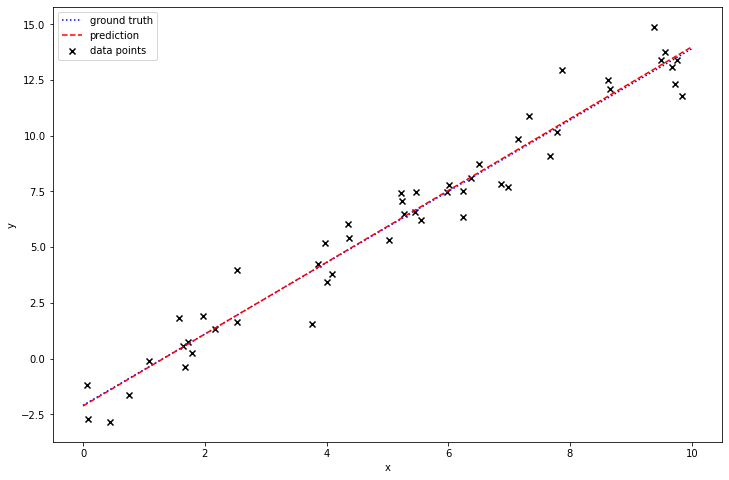

In [24]:
plot(x, y, (target_m, target_c), model_weights.data.squeeze().tolist())

In [25]:
print("Target params:\t\t", [target_m, target_c])
print("Predicted params:\t", model_weights.data.squeeze().tolist())

Target params:		 [1.6, -2.1]
Predicted params:	 [1.611430287361145, -2.128779649734497]


Great! The final model we found matches our ground truth pretty well, despite only having 50 noisy data points to fit to.

See the MLP notebook for a more complex example, including the use of layers.